In [1]:
from datasets import load_dataset
from PIL import ImageDraw, Image
from torch.utils.data import default_collate
from functools import partial
from transformers import ViTFeatureExtractor, ViTForImageClassification, TrainingArguments, Trainer

from computer_vision.vit_transformers.func.ultil import transform, compute_metrics

# Unit Check

In [2]:
ds = load_dataset('beans')
ex = ds['train'][400]
ex

Found cached dataset beans (C:/Users/Kevin/.cache/huggingface/datasets/beans/default/0.0.0/90c755fb6db1c0ccdad02e897a37969dbf070bed3755d4391e269ff70642d791)


  0%|          | 0/3 [00:00<?, ?it/s]

{'image_file_path': 'C:\\Users\\Kevin\\.cache\\huggingface\\datasets\\downloads\\extracted\\0c08c0df28e72cf903074cf8a5423199131cd3c3bf5c7552d4a70a3bd8e8028a\\train\\bean_rust\\bean_rust_train.148.jpg',
 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x500>,
 'labels': 1}

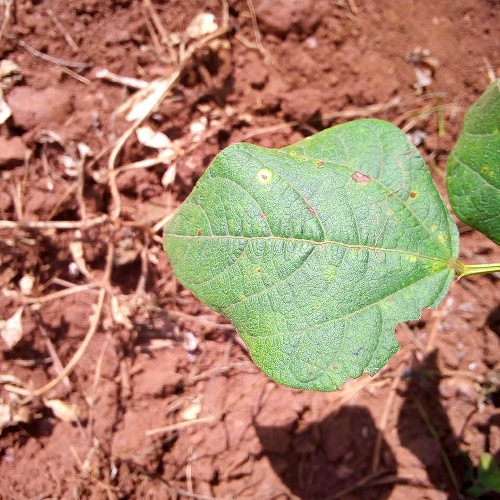

In [3]:
ex['image']

In [4]:
labels = ds['train'].features['labels']
labels.int2str(ex['labels'])

'bean_rust'

Loading cached processed dataset at C:/Users/Kevin/.cache/huggingface/datasets/beans/default/0.0.0/90c755fb6db1c0ccdad02e897a37969dbf070bed3755d4391e269ff70642d791\cache-b1b2071d4d02d39a.arrow
Loading cached shuffled indices for dataset at C:/Users/Kevin/.cache/huggingface/datasets/beans/default/0.0.0/90c755fb6db1c0ccdad02e897a37969dbf070bed3755d4391e269ff70642d791\cache-86a38aa1e666281f.arrow
Loading cached processed dataset at C:/Users/Kevin/.cache/huggingface/datasets/beans/default/0.0.0/90c755fb6db1c0ccdad02e897a37969dbf070bed3755d4391e269ff70642d791\cache-a6ee8e9cc0cb3d05.arrow
Loading cached shuffled indices for dataset at C:/Users/Kevin/.cache/huggingface/datasets/beans/default/0.0.0/90c755fb6db1c0ccdad02e897a37969dbf070bed3755d4391e269ff70642d791\cache-02145e7fedac18df.arrow
Loading cached processed dataset at C:/Users/Kevin/.cache/huggingface/datasets/beans/default/0.0.0/90c755fb6db1c0ccdad02e897a37969dbf070bed3755d4391e269ff70642d791\cache-72df3ad97e91c460.arrow
Loading cache

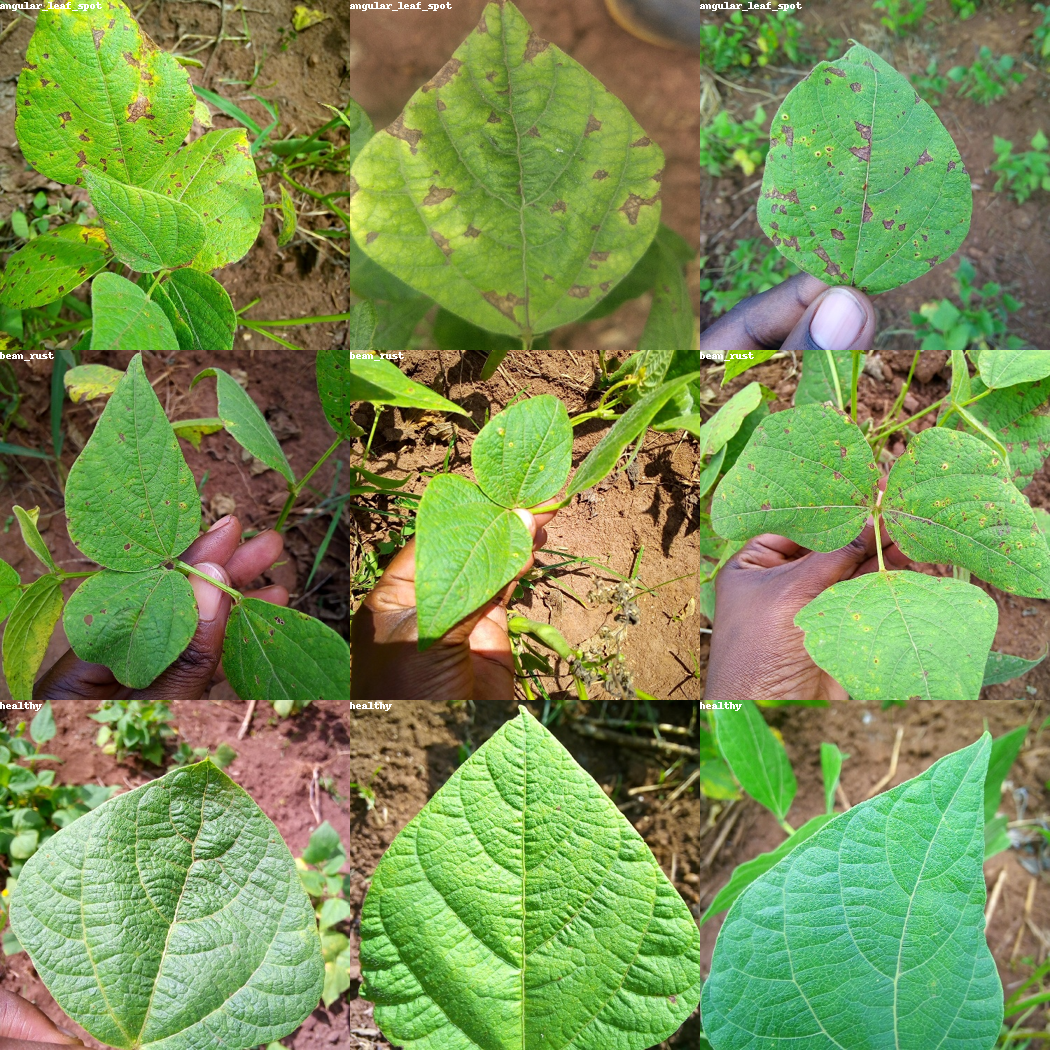

In [5]:
def show_examples(data, seed=42, examples_per_class=3, size=(350, 350)):
    w, h = size
    label_example = data.features['labels'].names
    grid = Image.new('RGB', size=(examples_per_class * w, len(label_example) * h))
    draw = ImageDraw.Draw(grid)

    for lid, label in enumerate(label_example):
        # Filter the dataset by a single label, shuffle it, and grab a few samples
        ds_slice = (
            ds['train']
            .filter(lambda x: x['labels'] == lid)
            .shuffle(seed)
            .select(range(examples_per_class))
        )

        # Plot this label's examples along a row
        for i, example in enumerate(ds_slice):
            img = example['image']
            idx = examples_per_class * lid + i
            box = (idx % examples_per_class * w, idx // examples_per_class * h)
            grid.paste(img.resize(size), box=box)
            draw.text(box, label, (255, 255, 255))
    return grid


show_examples(ds['train'], examples_per_class=3)

# Model

In [7]:
model_name = 'google/vit-base-patch16-224-in21k'
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name)
f = partial(transform, feature_extractor)
prepared_ds = ds.with_transform(f)

In [8]:
labels = ds['train'].features['labels'].names

model = ViTForImageClassification.from_pretrained(
    model_name,
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)}
)

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
training_args = TrainingArguments(
    output_dir="./vit_beans",
    per_device_train_batch_size=16,
    evaluation_strategy="steps",
    num_train_epochs=4,
    fp16=True,
    save_steps=100,
    eval_steps=100,
    logging_steps=10,
    learning_rate=2e-4,
    save_total_limit=2,
    remove_unused_columns=False,
    push_to_hub=False,
    load_best_model_at_end=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=default_collate,
    compute_metrics=compute_metrics,
    train_dataset=prepared_ds["train"],
    eval_dataset=prepared_ds["validation"],
    tokenizer=feature_extractor,
)

Using cuda_amp half precision backend


In [10]:
train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

C:\Users\Kevin\miniconda3\envs\nlp\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 1034
  Num Epochs = 4
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 260
  Number of trainable parameters = 85800963
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: kevinkhang. Use `wandb login --relogin` to force relogin


Step,Training Loss,Validation Loss


***** Running Evaluation *****
  Num examples = 133
  Batch size = 8
Saving model checkpoint to ./vit_beans\checkpoint-100
Configuration saved in ./vit_beans\checkpoint-100\config.json
Model weights saved in ./vit_beans\checkpoint-100\pytorch_model.bin
Feature extractor saved in ./vit_beans\checkpoint-100\preprocessor_config.json
***** Running Evaluation *****
  Num examples = 133
  Batch size = 8
Saving model checkpoint to ./vit_beans\checkpoint-200
Configuration saved in ./vit_beans\checkpoint-200\config.json
Model weights saved in ./vit_beans\checkpoint-200\pytorch_model.bin
Feature extractor saved in ./vit_beans\checkpoint-200\preprocessor_config.json


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./vit_beans\checkpoint-200 (score: 0.025782933458685875).
Saving model checkpoint to ./vit_beans
Configuration saved in ./vit_beans\config.json
Model weights saved in ./vit_beans\pytorch_model.bin
Feature extractor saved in ./

***** train metrics *****
  epoch                    =         4.0
  total_flos               = 298497957GF
  train_loss               =      0.1216
  train_runtime            =  0:01:08.05
  train_samples_per_second =      60.776
  train_steps_per_second   =       3.821


In [11]:
metrics = trainer.evaluate(prepared_ds['validation'])
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** Running Evaluation *****
  Num examples = 133
  Batch size = 8


***** eval metrics *****
  epoch                   =        4.0
  eval_accuracy           =     0.9925
  eval_loss               =     0.0258
  eval_runtime            = 0:00:02.90
  eval_samples_per_second =     45.759
  eval_steps_per_second   =      5.849


In [12]:
trainer